In this notebook, you will perform transfer learning to train CIFAR-10 dataset on ResNet50 model available in Keras.

In [1]:
try:
  %tensorflow_version 2.x
except:
  pass

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

In [3]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


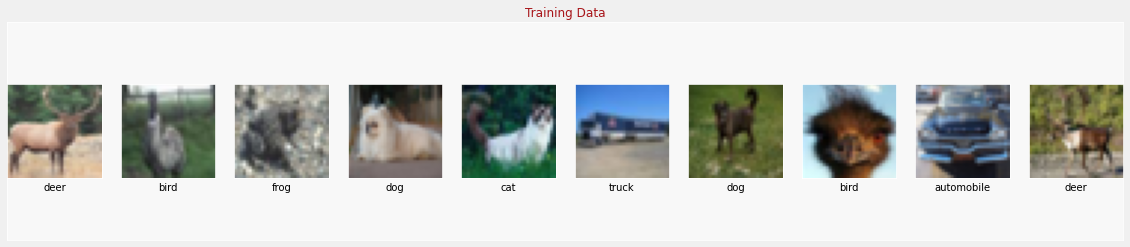

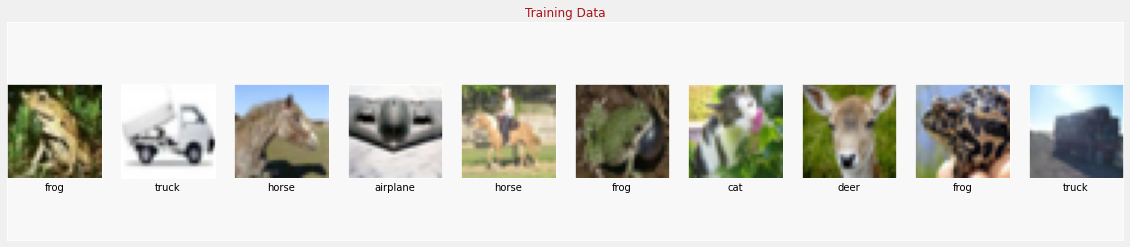

In [4]:
# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

display_images(training_images, training_labels, training_labels, "Training Data" )
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

In [5]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

Xtrain = preprocess_image_input(training_images)
Xval = preprocess_image_input(validation_images)

In [6]:
def feature_extractor(inputs):
  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor

In [7]:
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

In [8]:
def build_model():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)
    model = tf.keras.models.Model(inputs, classification_output)
    model.compile(optimizer='adam', 
                 loss='sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    return model
    
model = build_model()
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
______________________________________________________________

In [9]:
history = model.fit(Xtrain, training_labels, 
                    epochs=4, validation_data = (Xval, validation_labels), 
                    batch_size=64, 
                    verbose=1)

Epoch 1/4
782/782 [==============================] - 575s 685ms/step - loss: 1.0388 - accuracy: 0.6463 - val_loss: 0.9621 - val_accuracy: 0.6969
Epoch 2/4
782/782 [==============================] - 535s 685ms/step - loss: 0.4314 - accuracy: 0.8525 - val_loss: 0.5330 - val_accuracy: 0.8236
Epoch 3/4
782/782 [==============================] - 534s 683ms/step - loss: 0.2980 - accuracy: 0.8965 - val_loss: 0.5424 - val_accuracy: 0.8204
Epoch 4/4
782/782 [==============================] - 534s 683ms/step - loss: 0.2208 - accuracy: 0.9241 - val_loss: 0.5763 - val_accuracy: 0.8282


In [12]:
loss, accuracy = model.evaluate(Xval, validation_labels, batch_size=64)


157/157 [==============================] - 33s 207ms/step - loss: 0.5763 - accuracy: 0.8282


In [ ]:
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

plot_metrics("loss", "Loss")
plot_metrics("accuracy", "Accuracy")


In [ ]:
probabilities = model.predict(Xval, batch_size=64)
probabilities = np.argmax(probabilities, axis=1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")